## 1. Preliminary

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
from utils import load_records_from_csv

## 2. Load and inspect the dataset

In [6]:
# Load config file and get the path of csv files
with open("./config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
PAPER_LIST = Path(config["data"]["paper"]["node"])
PAPER_LIST = Path(PAPER_LIST)

In [7]:
df_combined = load_records_from_csv(PAPER_LIST)

In [8]:
# Expand the authors and references to original list
df_combined['authors'] = df_combined['authors'].str.split('#')
df_combined['references'] = df_combined['references'].str.split('#')

In [9]:
df_combined.head()

,id,title,authors,year,venue,references,out_d,in_d
0,555036b37cea80f954149ffc,Approximate Distance Oracles with Improved Que...,[Christian Wulff-Nilsen],2015,Encyclopedia of Algorithms,NaN,0,0
1,555036b37cea80f954149ffd,Subset Sum Algorithm for Bin Packing.,[Julián Mestre],2015,Encyclopedia of Algorithms,NaN,0,0
2,555036b37cea80f954149ffe,Minimum Weighted Completion Time.,"[V. S. Anil Kumar, Madhav V. Marathe, Srinivas...",2015,Encyclopedia of Algorithms,NaN,0,0
3,555036b37cea80f954149fff,Multiple String Matching.,"[Maxime Crochemore, Thierry Lecroq]",2015,Encyclopedia of Algorithms,NaN,0,0
4,555036b37cea80f95414a000,Fault-Tolerant Connected Dominating Set.,"[Donghyun Kim, Wei Wang, Weili Wu, Alade O. To...",2015,Encyclopedia of Algorithms,NaN,0,0


In [10]:
df_no_nan = df_combined.dropna()
df_no_nan.head()

,id,title,authors,year,venue,references,out_d,in_d
321825,5736953f6e3b12023e46e080,Seven Steps to Rendezvous with the Casual User.,[E. F. Codd],1974,IFIP Working Conference Data Base Management,"[5736955c6e3b12023e484b89, 5736955d6e3b12023e4...",18,0
321826,5736953f6e3b12023e46e081,Interactive Support for Non-Programmers: The R...,"[E. F. Codd, C. J. Date]",1974,"IBM Research Report, San Jose, California",[5736972c6e3b12023e61e097],1,0
321827,5736953f6e3b12023e46e082,Common Subexpression Identification in General...,[Patrick A. V. Hall],1974,"Technical Rep. UKSC 0060, IBM United Kingdom S...","[5736955d6e3b12023e484d00, 573696856e3b12023e5...",10,0
321829,5736953f6e3b12023e46e084,Principles of Distributed Object Database Lang...,[Markus Tresch],1996,"technical Report 248, ETH Zürich, Dept. of Com...",[5736972c6e3b12023e61df67],1,0
321830,5736953f6e3b12023e46e085,Relational Completeness of Data Base Sublangua...,[E. F. Codd],1972,"In: R. Rustin (ed.): Database Systems: 65-98, ...","[5736955c6e3b12023e484b50, 5736955c6e3b12023e4...",174,0


## 3. Count NaN values

In [11]:
nan_counts = df_combined.isna().sum()
print(nan_counts)

id                  0
title               0
authors         52010
year                0
venue           56785
references    1906376
out_d               0
in_d                0
dtype: int64


## 4. Plot the distribution of list columns

In [12]:
# Ensure that NaN values are handled by converting them to empty lists
df_combined["authors"] = df_combined["authors"].apply(
    lambda x: x if isinstance(x, list) and x != [""] else []
)

# Calculate the number of authors and references for each row
df_combined["num_authors"] = df_combined["authors"].apply(len)

# Calculate basic statistics
print(df_combined["num_authors"].describe())
print("=" * 20)
print(df_combined["out_d"].describe())
print("=" * 20)
print(df_combined["in_d"].describe())

count    3.680007e+06
mean     2.836479e+00
std      1.748325e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.390000e+02
Name: num_authors, dtype: float64
count    3.680007e+06
mean     5.097998e-01
std      1.294739e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.090000e+02
Name: out_d, dtype: float64
count    3.680007e+06
mean     5.097998e-01
std      1.059119e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.067000e+03
Name: in_d, dtype: float64


count    3.626640e+06
mean     2.867512e+00
std      1.640951e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      2.000000e+01
Name: num_authors, dtype: float64


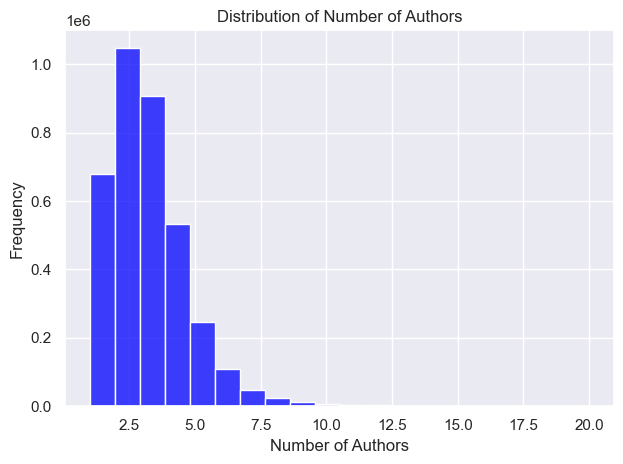

In [13]:
df_filtered_authors = df_combined[(df_combined['num_authors'] > 0) & (df_combined['num_authors'] <= 20)]
print(df_filtered_authors["num_authors"].describe())

# Plot the distribution of the number of authors
sns.histplot(df_filtered_authors['num_authors'], color='blue', bins=20)
plt.title('Distribution of Number of Authors')
plt.xlabel('Number of Authors')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

count    1.773552e+06
mean     1.050111e+00
std      1.073527e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.900000e+01
Name: out_d, dtype: float64


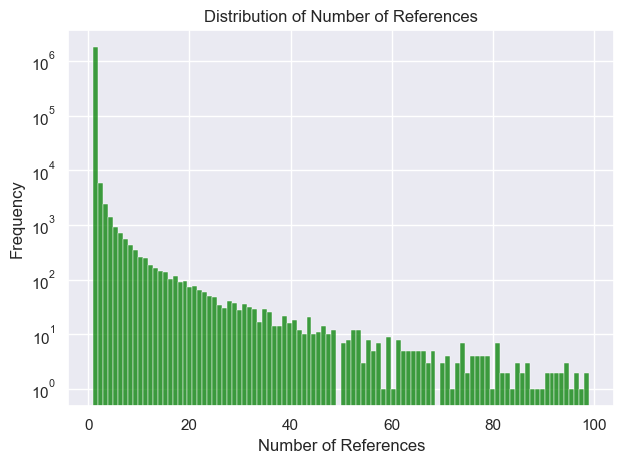

In [20]:
df_filtered_out_d = df_combined[(df_combined['out_d'] > 0) & (df_combined['out_d'] <= 100)]
print(df_filtered_out_d["out_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_out_d['out_d'], color='green', bins=100)
plt.title('Distribution of Number of References')
plt.xlabel('Number of References')
plt.ylabel('Frequency')
plt.yscale("log")
plt.tight_layout()
plt.show()

count    35162.000000
mean        29.818099
std         22.514989
min          1.000000
25%         13.000000
50%         23.000000
75%         41.000000
max        100.000000
Name: in_d, dtype: float64


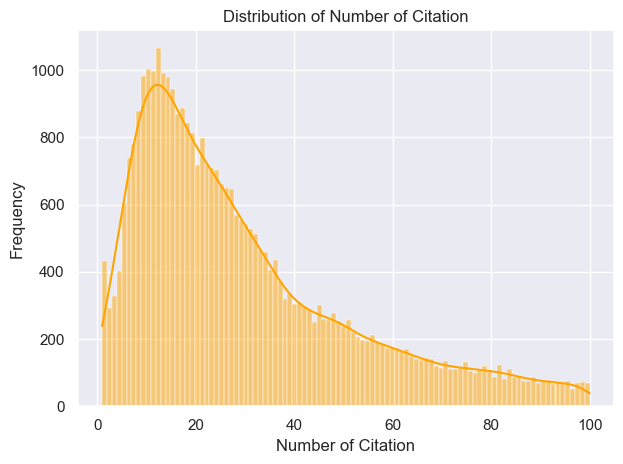

In [23]:
df_filtered_in_d = df_combined[(df_combined['in_d'] > 0) & (df_combined['in_d'] <= 100)]
print(df_filtered_in_d["in_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_in_d['in_d'], color='orange', kde=True, bins=100)
plt.title('Distribution of Number of Citation')
plt.xlabel('Number of Citation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()